In [26]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

from dotenv import load_dotenv
load_dotenv()

PATH_TO_PLANTNET_300K = os.environ.get('PATH_TO_PLANTNET_300K')

def count_folders(directory):
    return len([name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))])

train_set = f'{PATH_TO_PLANTNET_300K}/train_temp'

import resnet

print(f"Number of folders: {count_folders(train_set)}")

metrics = resnet.train_and_evaluate(num_epochs=4, num_classes = count_folders(train_set))

Number of folders: 10
Epoch [1/4], Loss: 0.4966
Epoch [2/4], Loss: 0.2235
Epoch [3/4], Loss: 0.1722
Epoch [4/4], Loss: 0.1500


#### Saving metrics to file 

In [32]:
import pickle

# Save metrics to a file
with open('metrics_data.pkl', 'wb') as f:
    pickle.dump(metrics, f)


In [33]:
# Load metrics from a file
with open('metrics_data.pkl', 'rb') as f:
    loaded_metrics = pickle.load(f)

#### data in CLI

In [34]:
for epoch_data in loaded_metrics:
        print(f"\nEpoch {epoch_data['epoch']} Metrics:")
        print(f"Loss: {epoch_data['loss']:.4f}")
        print(f"Overall Accuracy: {epoch_data['overall_accuracy']:.2f}%")
        print(f"Confusion Matrix:\n{epoch_data['confusion_matrix']}")
        print(f"report {epoch_data['classification_report']}")
        print("Top 5 classes with the best recall:")
        for cls, recall in epoch_data['top_5_best_recall']:
            print(f"Class {cls}: {recall:.2f}")

        print("\nTop 5 classes with the worst recall:")
        for cls, recall in epoch_data['top_5_worst_recall']:
            print(f"Class {cls}: {recall:.2f}")


Epoch 1 Metrics:
Loss: 0.4966
Overall Accuracy: 94.73%
Confusion Matrix:
[[147   1   3   0   0   0   0   0   1   2]
 [  3  45   4   0   0   1   1   0   0   0]
 [  1   2  62   1   0   0   1   0   0   0]
 [  2   2   3  85   0   1   1   0   0   0]
 [  1   0   0   0  27   1   0   1   0   0]
 [  4   2   2   0   6 196   0   0   0   1]
 [  0   1   0   1   0   0 279   0   0   0]
 [  1   0   0   0   0   0   0 131   0   1]
 [  0   0   0   0   0   0   2   2  29   0]
 [  1   0   0   1   0   0   0   0   0  42]]
report {'1409238': {'precision': 0.91875, 'recall': 0.9545454545454546, 'f1-score': 0.9363057324840764, 'support': 154.0}, '1393425': {'precision': 0.8490566037735849, 'recall': 0.8333333333333334, 'f1-score': 0.8411214953271028, 'support': 54.0}, '1390637': {'precision': 0.8378378378378378, 'recall': 0.9253731343283582, 'f1-score': 0.8794326241134752, 'support': 67.0}, '1355990': {'precision': 0.9659090909090909, 'recall': 0.9042553191489362, 'f1-score': 0.9340659340659341, 'support': 94.0

### Confusion Matrix for Last Epoch 

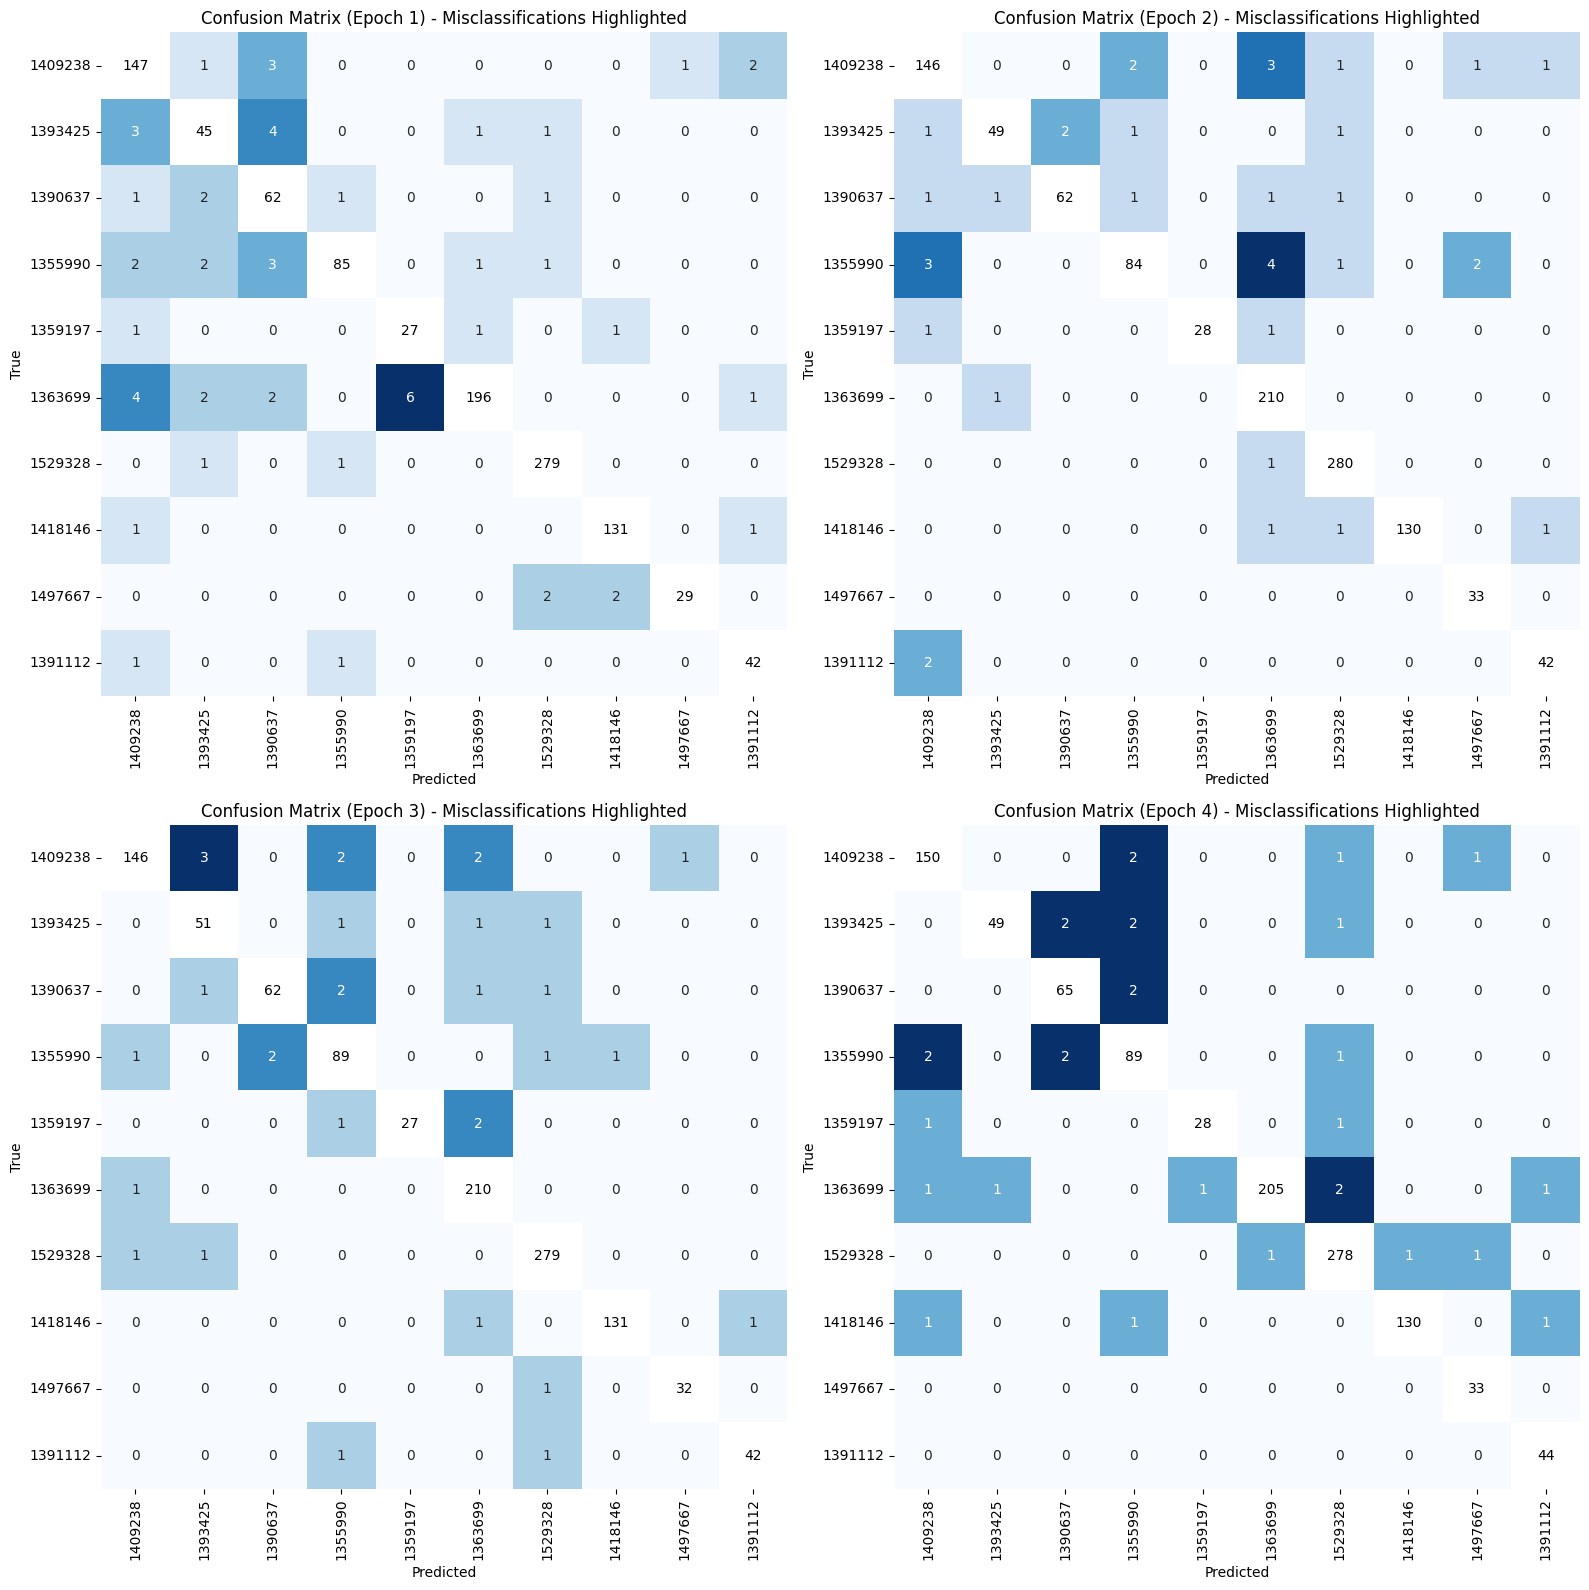

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Number of epochs (based on the number of metrics returned)
num_epochs = len(metrics)

# Calculate number of rows needed for a 2-column layout
n_rows = (num_epochs + 1) // 2  # Integer division rounding up if odd

# Create subplots with 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(16, n_rows * 8))  # Adjust figure size to match the number of rows

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop through each epoch and plot the confusion matrix
for epoch in range(num_epochs):
    # Get confusion matrix for the current epoch
    conf_matrix = metrics[epoch]['confusion_matrix']
    selected_classes = resnet.get_class_names(f'{PATH_TO_PLANTNET_300K}/train_temp')  # Modify this if necessary

    # Create a copy of the confusion matrix for coloring and mask the diagonal
    conf_matrix_for_coloring = conf_matrix.astype(float)
    np.fill_diagonal(conf_matrix_for_coloring, np.nan)

    # Plot the confusion matrix on the respective axis
    sns.heatmap(conf_matrix_for_coloring, annot=conf_matrix, fmt='d', cmap='Blues', ax=axes[epoch],
                xticklabels=selected_classes, yticklabels=selected_classes,
                mask=np.isnan(conf_matrix_for_coloring), cbar_kws={'label': 'Number of Misclassifications'}, 
                cbar=False)  # Disable cbar for clarity in multi-plot

    # Add diagonal values manually after coloring
    for i in range(len(conf_matrix)):
        axes[epoch].text(i + 0.5, i + 0.5, conf_matrix[i, i], ha="center", va="center", color="black", fontsize=10)

    # Set title for each plot
    axes[epoch].set_title(f'Confusion Matrix (Epoch {epoch + 1}) - Misclassifications Highlighted')

    # Modify x-axis labels to be vertical
    axes[epoch].tick_params(axis='x', rotation=90)

    # Set axis labels
    axes[epoch].set_xlabel('Predicted')
    axes[epoch].set_ylabel('True')

# Hide any unused subplots if number of epochs is odd
if num_epochs % 2 != 0:
    axes[-1].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()

